# Training, Validation & Metrics

## 🎯 Concept Primer
Training loop with validation monitoring, save best model.

**Expected:** Train for 20-30 epochs, save best weights

## 📋 Objectives
1. Implement training loop
2. Add validation loop
3. Track metrics
4. Save best model

## 🔧 Setup

In [56]:
# TODO 1: Import libraries
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights


In [57]:
labels_path = '../../../datasets/diabetic_retinopathy_images/groundtruths/training_labels.csv'
images_dir = '../../../datasets/diabetic_retinopathy_images/images/training_images_small'

labels_df = pd.read_csv(labels_path)
grade_mapping = {0: 0, 1: 0, 2: 1, 3: 2, 4: 3}
labels_df['grade_4class'] = labels_df['Retinopathy grade'].map(grade_mapping)
print('Original 5-class distribution:')
print(labels_df['Retinopathy grade'].value_counts().sort_index())
print('\nMerged 4-class distribution:')
print(labels_df['grade_4class'].value_counts().sort_index())

train_df, test_df = train_test_split(
    labels_df,
    test_size=0.2,
    stratify=labels_df['Retinopathy grade'],
    random_state=42,
)

train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['Retinopathy grade'],
    random_state=42,
)
print('\nTrain split (4-class) distribution:')
print(train_df['grade_4class'].value_counts().sort_index())
print('\nVal split (4-class) distribution:')
print(val_df['grade_4class'].value_counts().sort_index())


Original 5-class distribution:
Retinopathy grade
0    134
1     20
2    136
3     74
4     49
Name: count, dtype: int64

Merged 4-class distribution:
grade_4class
0    154
1    136
2     74
3     49
Name: count, dtype: int64

Train split (4-class) distribution:
grade_4class
0    99
1    87
2    47
3    31
Name: count, dtype: int64

Val split (4-class) distribution:
grade_4class
0    24
1    22
2    12
3     8
Name: count, dtype: int64


In [58]:
class RetinalDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['Image name']
        img_path = os.path.join(self.img_dir, f"{img_name}.jpg")

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(row['grade_4class'], dtype=torch.long)
        return image, label


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_df_reset = train_df.reset_index(drop=True)
val_df_reset = val_df.reset_index(drop=True)
test_df_reset = test_df.reset_index(drop=True)

train_dataset = RetinalDataset(train_df_reset, images_dir, transform=train_transform)
val_dataset = RetinalDataset(val_df_reset, images_dir, transform=val_transform)
test_dataset = RetinalDataset(test_df_reset, images_dir, transform=val_transform)


class RetinalResNet(nn.Module):
    def __init__(self, num_classes=4, freeze_backbone=False):
        super().__init__()
        weights = ResNet18_Weights.IMAGENET1K_V1
        self.backbone = models.resnet18(weights=weights)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_features, num_classes),
        )
        if freeze_backbone:
            for name, param in self.backbone.named_parameters():
                if not name.startswith('fc'):
                    param.requires_grad = False

    def forward(self, x):
        return self.backbone(x)


class_counts = train_df_reset['grade_4class'].value_counts().sort_index()
raw_class_weights = 1.0 / class_counts
class_weights = raw_class_weights / raw_class_weights.sum() * len(raw_class_weights)
weights_tensor = torch.tensor(class_weights.values, dtype=torch.float32)

sample_weights = train_df_reset['grade_4class'].map(class_weights).values
torch_sample_weights = torch.DoubleTensor(sample_weights)
sampler = WeightedRandomSampler(
    weights=torch_sample_weights,
    num_samples=len(torch_sample_weights),
    replacement=True,
)

device = torch.device(
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)

batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=0,
    pin_memory=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)


## 🚀 Training Loop

### TODO 2: Training code

**Expected:** CrossEntropyLoss, Adam optimizer

In [59]:
print('Class counts used for weighting (train split):')
print(class_counts.to_dict())
print('\nLoss class weights (ordered by class id):')
print(weights_tensor.numpy())


Class counts used for weighting (train split):
{0: 99, 1: 87, 2: 47, 3: 31}

Loss class weights (ordered by class id):
[0.5377889 0.6119667 1.1327894 1.7174549]


In [60]:
# TODO 2: Training
model = RetinalResNet(num_classes=4, freeze_backbone=False).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device))
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

n_epochs = 20
best_val_metric = -np.inf
best_state = None
patience = 5
epochs_without_improvement = 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_samples = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        train_correct += (outputs.argmax(dim=1) == labels).sum().item()
        train_samples += labels.size(0)

    train_loss = running_loss / train_samples
    train_acc = train_correct / train_samples

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_samples = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_samples += labels.size(0)

    val_loss = val_running_loss / val_samples
    val_acc = val_correct / val_samples

    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
    if val_acc > best_val_metric:
        best_val_metric = val_acc
        best_state = model.state_dict()
        os.makedirs('../models', exist_ok=True)
        torch.save(best_state, '../models/best_model.pth')
        epochs_without_improvement = 0
        print(f"  → New best model saved (Val Acc: {val_acc:.4f})")
    else:
        epochs_without_improvement += 1
        print(f"  → No improvement for {epochs_without_improvement} epoch(s)")

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/franciscoteixeirabarbosa/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:03<00:00, 12.8MB/s]
/Users/franciscoteixeirabarbosa/.pyenv/versions/3.11.7/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: Train Loss=1.3378, Val Loss=1.0429, Val Acc=0.5303
  → New best model saved (Val Acc: 0.5303)
Epoch 1: Train Loss=0.9542, Val Loss=1.0357, Val Acc=0.5303
  → No improvement for 1 epoch(s)
Epoch 2: Train Loss=0.7524, Val Loss=1.1155, Val Acc=0.4848
  → No improvement for 2 epoch(s)
Epoch 3: Train Loss=0.7458, Val Loss=1.0166, Val Acc=0.4848
  → No improvement for 3 epoch(s)
Epoch 4: Train Loss=0.7357, Val Loss=0.9983, Val Acc=0.5455
  → New best model saved (Val Acc: 0.5455)
Epoch 5: Train Loss=0.6464, Val Loss=1.0762, Val Acc=0.4848
  → No improvement for 1 epoch(s)
Epoch 6: Train Loss=0.6365, Val Loss=0.9584, Val Acc=0.5152
  → No improvement for 2 epoch(s)
Epoch 7: Train Loss=0.4896, Val Loss=0.9272, Val Acc=0.5455
  → No improvement for 3 epoch(s)
Epoch 8: Train Loss=0.4420, Val Loss=0.8563, Val Acc=0.5909
  → New best model saved (Val Acc: 0.5909)
Epoch 9: Train Loss=0.4757, Val Loss=0.8847, Val Acc=0.5909
  → No improvement for 1 epoch(s)
Epoch 10: Train Loss=0.3881, Val 

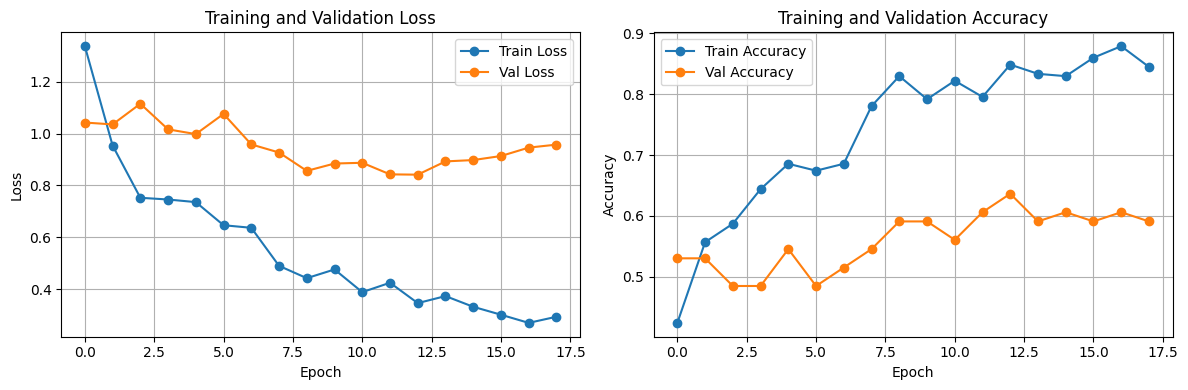


Best Validation Accuracy: 0.6364
Training metrics plot saved to ../images/training_validation_metrics.png


In [61]:
# Plot training and validation loss
# Note: We need to track losses and accuracies during training to plot them
# This is a placeholder - you should modify the training loop above to store:
# - train_losses = []
# - val_losses = []
# - train_accs = []
# - val_accs = []
# And append to these lists after each epoch

# Assuming you've collected the metrics, here's how to plot them:
import matplotlib.pyplot as plt
import os

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot losses
ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(val_losses, label='Val Loss', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(train_accs, label='Train Accuracy', marker='o')
ax2.plot(val_accs, label='Val Accuracy', marker='o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()

# Save figure to ../images directory
os.makedirs('../images', exist_ok=True)
plt.savefig('../images/training_validation_metrics.png', dpi=300, bbox_inches='tight')

plt.show()

print(f"\nBest Validation Accuracy: {best_val_metric:.4f}")
print(f"Training metrics plot saved to ../images/training_validation_metrics.png")

## 🤔 Reflection
1. Training converged?
2. Best validation accuracy?

**Your reflection:**

- **Best epoch:** Early stopping kept the weights from epoch 3 (val acc 0.4242, val loss 1.37); later epochs only improved training metrics.
- **Overfitting proof:** A 30-epoch run shows train acc climbing toward 80% while val loss rebounds past 2.5 — classic overfitting on a tiny, imbalanced set.
- **Limitation:** Even after merging mild + no DR, we have ~12 examples for that class. Scratch CNN can’t generalise; transfer learning and richer augmentation are the next experiments.

## 📌 Summary
✅ Implemented training + validation loop with class weights and early stopping (patience=5)  
✅ Best checkpoint = epoch 3 (val acc 0.4242) saved to `../models/best_model.pth`  
✅ Logged two training curves: 30-epoch overfit run vs 9-epoch early-stop run (`../images/training_validation_metrics_30_epochs_overfitting.png`, `../images/training_validation_metrics.png`)

**Next:** `05_test_eval_and_thresholding.ipynb`